# Clustering Lab

 
Based of the amazing work you did in the Movie Industry you've been recruited to the NBA! You are working as the VP of Analytics that helps support a head scout, Mr. Rooney, for the worst team in the NBA probably the Wizards. Mr. Rooney just heard about Data Science and thinks it can solve all the team's problems!!! He wants you to figure out a way to find players that are high performing but maybe not highly paid that you can steal to get the team to the playoffs! 

In this document you will work through a similar process that we did in class with the NBA data files will be in the canvas assignment, merging them together.

Details: 

- Determine a way to use clustering to estimate based on performance if 
players are under or over paid, generally. 

- Then select players you believe would be best for your team and explain why. Do so in three categories: 
    * Examples that are not good choices (3 or 4) 
    * Several options that are good choices (3 or 4)
    * Several options that could work, assuming you can't get the players in the good category (3 or 4)

- You will decide the cutoffs for each category, so you should be able to explain why you chose them.

- Provide a well commented and clean report of your findings in a separate notebook that can be presented to Mr. Rooney, keeping in mind he doesn't understand...anything. Include a rationale for variables you included in the model, details on your approach and a overview of the results with supporting visualizations. 


Hints:

- Salary is the variable you are trying to understand 
- When interpreting you might want to use graphs that include variables that are the most correlated with Salary
- You'll need to scale the variables before performing the clustering
- Be specific about why you selected the players that you did, more detail is better
- Use good coding practices, comment heavily, indent, don't use for loops unless totally necessary and create modular sections that align with some outcome. If necessary create more than one script,list/load libraries at the top and don't include libraries that aren't used. 
- Be careful for non-traditional characters in the players names, certain graphs won't work when these characters are included.


In [64]:
# load libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import silhouette_score

In [65]:
# loading data 
# needed to clarify that first row of salary data set were column headers

salary_data = pd.read_csv("2025_salaries.csv" , header=1)

# there are several odd characters, latin-1 encoding was needed
# needed to parse txt file with comma separation 

stats = pd.read_csv("nba_2025.txt" , sep = "," , encoding="latin-1")

In [66]:
# need to merge data frames
# will be doing an inner merge on the player column
merged_data = pd.merge(salary_data, stats, on = "Player")

In [67]:
# Drop variables that will not be needed or are duplicates
# there are duplicates of players when they play for multiple teams
# if a player played for multiple teams they have a row for each respective team
# they have a third row with a "2TM" value in the team column
# that row has their combined stats for that season
# I will use that row and drop the other two duplicates

# this pulls each row that is considered a duplicate
# and the first ocurrance and puts those rows into a new DF

duplicates = merged_data[merged_data.duplicated(subset="Player", keep=False)]

# this removes all rows where Team is 2TM
# leaving us with a df of all unwanted rows

unwanted_duplicates = duplicates[duplicates["Team"] != "2TM" ] 

# this drops all of the rows that have the index that matches 
# the index of the merged_data
# we are able to do this because we never reset the index

unique_data = merged_data.drop(unwanted_duplicates.index)

# now that we have removed all duplicates we can reset the index
unique_data = unique_data.reset_index()

In [68]:
# the current salary column is called "2025-26"
# lets rename that "Salary"

unique_data = unique_data.rename(columns={"2025-26" : "Salary"})

In [69]:
# check for mising values 
unique_data.isna().sum()

# Since Salary is our target variable, we will drop rows where NA is present in this column
# The other columns [3P%, 2P%, FT%, Awards] will be dropped altogether 
# dropping specific rows because they have missing values in these columns is not needed.

index                  0
Player                 0
Tm                     0
Salary                 4
Rk                     0
Age                    0
Team                   0
Pos                    0
G                      0
GS                     0
MP                     0
FG                     0
FGA                    0
FG%                    0
3P                     0
3PA                    0
3P%                   19
2P                     0
2PA                    0
2P%                    1
eFG%                   0
FT                     0
FTA                    0
FT%                    3
ORB                    0
DRB                    0
TRB                    0
AST                    0
STL                    0
BLK                    0
TOV                    0
PF                     0
PTS                    0
Trp-Dbl                0
Awards               416
Player-additional      0
dtype: int64

In [70]:
# dropping rows where salary is NA

unique_data = unique_data.dropna(subset=["Salary"])

In [71]:
# looking at all column names to determine which columns I want to keep
# Columns kept should correlate to productivity and value

COLS = unique_data.columns
COLS

Index(['index', 'Player', 'Tm', 'Salary', 'Rk', 'Age', 'Team', 'Pos', 'G',
       'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%',
       'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
       'TOV', 'PF', 'PTS', 'Trp-Dbl', 'Awards', 'Player-additional'],
      dtype='str')

In [72]:
# Columns kept will be ["Player" , "Salary" , "FG" , "TRB" , "AST" , "STL" , "BLK" , "G" ]
# because they are columns that track offensive and defensive production on the court during a game

keep_cols = ["Player" , "Salary" , "FG" , "TRB" , "AST" , "STL" , "BLK", "G" ]
unique_data = unique_data[keep_cols]

In [73]:
# Lets check the dtypes of each column 
unique_data.info()


<class 'pandas.DataFrame'>
RangeIndex: 412 entries, 0 to 411
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  412 non-null    str    
 1   Salary  412 non-null    str    
 2   FG      412 non-null    float64
 3   TRB     412 non-null    float64
 4   AST     412 non-null    float64
 5   STL     412 non-null    float64
 6   BLK     412 non-null    float64
 7   G       412 non-null    float64
dtypes: float64(6), str(2)
memory usage: 25.9 KB


In [74]:
# All columns are of the correct dtype except for Salary 
# It should be a float but is a string
# lets turn it into a float so we can standardize the data

# first we need to strip the values of the $ and comma

unique_data["Salary"] = (
    unique_data["Salary"]
    .str.replace("$" , "", regex = False)
    .str.replace("," , "" , regex = False)
)

# then we need to convert it from a string to a float

unique_data["Salary"] = unique_data["Salary"].astype(float)

In [75]:
# now we can scale all necessary columns with MinMaxScaler

cols_to_scale = ["FG" , "TRB", "AST", "STL", "BLK", "Salary" , "G"]

scaler = MinMaxScaler()

scaled_data = unique_data.copy()

scaled_data[cols_to_scale] = scaler.fit_transform(
    scaled_data[cols_to_scale]
)


In [76]:
#Run the clustering algo with your best guess for K
# my best guess for K is going to be 4.

# we need to create a new dataset that does not have player names in it

X = scaled_data.drop(columns=["Player"])

# Creating an instance of the model
my_model = KMeans(n_clusters=4 , random_state=42)

# fitting the model to the data
my_model.fit(X)

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",4
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",42
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


In [77]:
# this is the cluster assignments for each row

predictions = my_model.predict(X)


In [78]:
# score is similar to inertia except the negative version
# a value closer to 0 is better

performance = my_model.score(X)
performance

-47.73061001354901

In [79]:
#View the results

# first I am going to add the cluster label to each row

scaled_data["Cluster"] = my_model.labels_

# look at the break down of data points in each cluster to see if there is a good split

scaled_data["Cluster"].value_counts()

# this looks like a good split, there are sufficient data points in each group

Cluster
0    163
2    107
3     97
1     45
Name: count, dtype: int64

In [80]:
# we need to understand the charcteristics of each cluster
# lets see what the mean is of each stat for each cluster

cols = ["FG" , "TRB", "AST", "STL", "BLK", "Salary" , "G"]
cluster_summary = scaled_data.groupby("Cluster")[cols].mean()
cluster_summary

# looking at this data cluster 1 is most likely our all-stars because they have 
# the highest salary, second highest games played, and relatively high stats
# the best value candidates are probably going to be from cluster 3
# they have the highest games played, a pretty low average salary
# and pretty good stats all around
# the next best choice would be cluster 0 becayse they also have
# a pretty low salary and a relatively high games played average
# however their stats are not really that high

# Rank: Cluster 3 (highest value), Cluster 1 (All-Stars), Cluster 0 (decent and cheap player), Cluster 2 (do not acquire)

,FG,TRB,AST,STL,BLK,Salary,G
Cluster,,,,,,,
0,0.221054,0.226398,0.161830,0.261890,0.144924,0.128755,0.734151
1,0.656097,0.422222,0.486529,0.467278,0.247799,0.701716,0.776955
2,0.066663,0.069685,0.050203,0.069193,0.039058,0.107940,0.319315
3,0.464477,0.454220,0.344517,0.452662,0.300233,0.178375,0.891371


In [81]:
#Create a visualization of the results with 2 or 3 variables that you think will best
#differentiate the clusters

# this plot compares games played and FG but also takes into account salary as the hue and 
# makes the symbol of each cluster be the shape of the data point
# if you hover over the
fig = px.scatter(
    scaled_data,
    x="G",
    y="FG",
    color="Salary",         
    symbol="Cluster",        
    color_continuous_scale="viridis",  
    hover_data=["Player", "Salary", "AST", "TRB"]
)

fig.update_layout(
    title="Clusters by G and FG",
    xaxis_title="Games (G)",
    yaxis_title="Field Goals (FG)",
    legend=dict(x=0.01, y=0.99),
    coloraxis_colorbar=dict(x=1.1)

)

fig.show()

In [82]:
#Evaluate the quality of the clustering using total variance explained and silhouette scores

# Total Sum of Squares (TSS) measures the overall
# spread of the data before clustering.
# It represents total variance in the dataset.

# Compute overall mean of the scaled features
overall_mean = np.mean(X, axis=0)

# Compute total variance (TSS)
tss = np.sum((X - overall_mean) ** 2)

# inertia measures how tightly
# points are grouped around their cluster centroids.
# Lower WSS = tighter clusters.

inertia = my_model.inertia_

# BSS = TSS - inertia
# This measures how much variance is explained
# by separating data into clusters.

bss = tss - inertia

# This tells us what proportion of total variance
# is explained by the clustering structure.

variance_explained = bss / tss

# Silhouette score measures how well-separated
# the clusters are.
# Range: -1 to 1
#   ~1   → very strong separation
#   ~0.5 → reasonable
#   ~0   → overlapping clusters
#   <0   → poor clustering

sil_score = silhouette_score(X, my_model.labels_)

print("Total Variance (TSS):", tss)
print("Within-Cluster Variance (Inertia):", inertia )
print("Between-Cluster Variance (BSS):", bss)
print("Variance Explained:", variance_explained)
print("Silhouette Score:", sil_score)

# our WSS and TSS look pretty good, there is a strong gap
# our sil_score could be higher, but when things are scaled they are closer together

Total Variance (TSS): 125.35248242556385
Within-Cluster Variance (Inertia): 47.73061001354901
Between-Cluster Variance (BSS): 77.62187241201484
Variance Explained: 0.6192288410252095
Silhouette Score: 0.2818318462712326


In [83]:
#Determine the ideal number of clusters using the elbow method and the silhouette coefficient

# lets determine which k-value gives the inertia value closest to 0 
# this will allow me to use the strongest k value moving forward

# we need to create a new dataset that does not have player names in it

X = scaled_data.drop(columns=["Player"])

# create an empty list to store results

results = []

# need to run a for loop itterating through each k-value 
# find the intertia value that corresponds to each k value
# store both the k value and intertia value as a tuple inside the list
# turn the list into a DF with columns K and intertia
# this can be used create an elbow plot

for k in range(2, 15):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    results.append((k, model.inertia_))

results_df = pd.DataFrame(results, columns=["k", "inertia"])

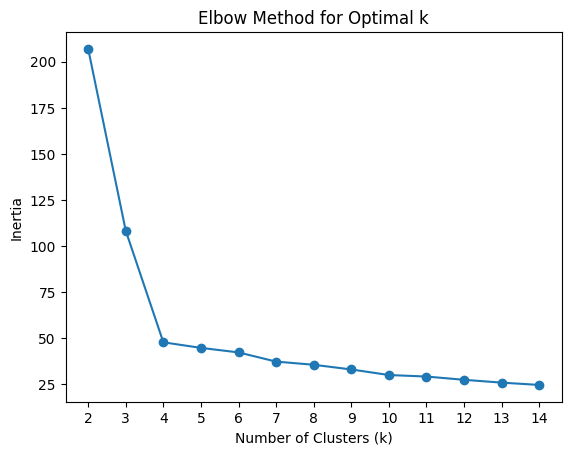

In [84]:
#Visualize the results of the elbow method

# make an elbow plot 
# based on the plot below, 4 clusters seems to be the best.
plt.figure()
plt.plot(results_df["k"], results_df["inertia"], marker="o")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")

plt.xticks(results_df["k"]) 

plt.show()

In [85]:
#Use the recommended number of cluster (assuming it's different) to retrain your model and visualize the results

# model was the same but I will paste and run the cells down here

fig = px.scatter(
    scaled_data,
    x="G",
    y="FG",
    color="Salary",         
    symbol="Cluster",        
    color_continuous_scale="viridis",  
    hover_data=["Player", "Salary", "AST", "TRB"]
)

fig.update_layout(
    title="Clusters by G and FG",
    xaxis_title="Games (G)",
    yaxis_title="Field Goals (FG)",
    legend=dict(x=0.01, y=0.99),
    coloraxis_colorbar=dict(x=1.1)

)

fig.show()


In [86]:
#Once again evaluate the quality of the clustering using total variance explained and silhouette scores
# Pasted cell from above because 4 clusters was already optimal
# view earlier cell to see calculations of these variables

print("Total Variance (TSS):", tss)
print("Within-Cluster Variance (Inertia):", inertia )
print("Between-Cluster Variance (BSS):", bss)
print("Variance Explained:", variance_explained)
print("Silhouette Score:", sil_score)

# our WSS and TSS look pretty good, there is a strong gap
# our sil_score could be higher, but when things are scaled they are closer together

Total Variance (TSS): 125.35248242556385
Within-Cluster Variance (Inertia): 47.73061001354901
Between-Cluster Variance (BSS): 77.62187241201484
Variance Explained: 0.6192288410252095
Silhouette Score: 0.2818318462712326


In [87]:
#Use the model to select players for Mr. Rooney to consider

# looking at this data cluster 1 is most likely our all-stars because they have 
# the highest salary, second highest games played, and relatively high stats
# the best value candidates are probably going to be from cluster 3
# they have the highest games played, a pretty low average salary
# and pretty good stats all around
# the next best choice would be cluster 0 becayse they also have
# a pretty low salary and a relatively high games played average
# however their stats are not really that high

cluster_summary

# Rank: Cluster 3 (highest value), Cluster 1 (All-Stars), Cluster 0 (decent and cheap player), Cluster 2 (do not acquire)


,FG,TRB,AST,STL,BLK,Salary,G
Cluster,,,,,,,
0,0.221054,0.226398,0.161830,0.261890,0.144924,0.128755,0.734151
1,0.656097,0.422222,0.486529,0.467278,0.247799,0.701716,0.776955
2,0.066663,0.069685,0.050203,0.069193,0.039058,0.107940,0.319315
3,0.464477,0.454220,0.344517,0.452662,0.300233,0.178375,0.891371


In [ ]:
# - Then select players you believe would be best for your team and explain why. Do so in three categories: 

# Three players that are not good choices would most likely be in cluster 1
# Players in this category have a very high salary
# However, their production does not match how much they are being payed 
# this means that you are overpaying for how much production you would get out of these players

scaled_data[
    scaled_data["Player"].isin(
        ["Anthony Davis", "Paul George", "Joel Embiid"]
    )
]
# The players shown below are horrible choices. Their salaries are all above 0.85 which means
# they are being payed above a large majority of the players in this data set
# however, their production in every single category, except for FG for Joel Embiid 
# are below 0.4, which means that their production is pretty mediocre, and largely poor
# if you take into account how much money you are paying them
# also, none of them play anywhere near a full season, meaning you are paying them
# a higher average per game, leaving a lot of money on the table that could be used to get a player
# that plays more, and have more production.

# If a player has a salary above 0.7, stats below 0.3, and G below 0.5, stay away no matter what.


,Player,Salary,FG,TRB,AST,STL,BLK,G,Cluster
401,Paul George,0.866414,0.280899,0.228995,0.221239,0.366972,0.122642,0.462963,1
408,Anthony Davis,0.907804,0.316479,0.364086,0.123894,0.201835,0.311321,0.333333,1
410,Joel Embiid,0.926277,0.520599,0.382208,0.267699,0.183486,0.320755,0.537037,1


In [ ]:
# * Several options that are good choices (3 or 4)

scaled_data[
    scaled_data["Player"].isin(
        ["Kon Knueppel", "Amen Thompson", "Nickeil Alexander-Walker"]
    )
]
# The players shown below are Grade-A choices. Their salaries are all below 0.26which means
# they are being payed below a large majority of the players in this data set
# Also, their production is near average, or above average in most categories. 
# All of them have G above 0.9 meaning they play a large majority of the seaon.
# What this means is that you can pay them next to nothing compared to the rest of the league,
# They will have above average production in at least 2 stat categories, and will do this for the 
# large majority of the season, giving you the value for the money that you are paying them.
# This also allows you to surround an All-Star player with highly productive, affordable players.

# If a player has a salary at or below 0.25, at least 2 stats above 0.5, and G above 0.9,
# that is going to be your perfect player.

,Player,Salary,FG,TRB,AST,STL,BLK,G,Cluster
254,Amen Thompson,0.160264,0.661049,0.649094,0.621681,0.678899,0.301887,0.925926,3
257,Kon Knueppel,0.165733,0.655431,0.489292,0.424779,0.339450,0.122642,0.962963,3
314,Nickeil Alexander-Walker,0.252306,0.689139,0.321252,0.442478,0.577982,0.311321,0.962963,3


In [98]:
# * Several options that could work, assuming you can't get the players in the good category (3 or 4)

scaled_data[
    scaled_data["Player"].isin(
        ["Ivica Zubac" , "Jarrett Allen" , "Brandon Miller"]
    )
]

# These players are also relatively good-value options, but their stats are not nearly as solid throughout.
# Brandon Miller has a pretty low salary, decent FG, STL, and BLK stats, but playes a little over half of the 
# season, meaning you probably won't get this production over the course of the entire season. However, his low salary
# gives you the flexibility to potentially find a higher salary candidate. Ivica Zubac has a higher salary, and extremely high TRB
# stat, and a pretty good BLK and FG stat, but he only playes around 3/4 of the season, again missing out on potential production
# throughout the entire season. Finally, Jarrett Allen, also has a higher salary, pretty good FG and TRB stats, with decent
# STL and BLK stats, but again he only plays around 3/4 of the season, missing out on potential production. All of these cadidates are 
# pretty good choices, but they are not as solid in every category as the previous three names. 

# If they have a salary below 0.35, at least 2 stats above 0.3, a separate stat that is above 0.5, and G above 0.65,
# these are relatively good value picks, but maybe not the best.


,Player,Salary,FG,TRB,AST,STL,BLK,G,Cluster
283,Brandon Miller,0.198590,0.505618,0.296540,0.276549,0.366972,0.320755,0.666667,3
324,Ivica Zubac,0.301768,0.492509,0.779242,0.212389,0.146789,0.339623,0.759259,3
334,Jarrett Allen,0.333698,0.464419,0.586491,0.188053,0.385321,0.349057,0.759259,3


In [89]:
#Write up the results in a separate notebook with supporting visualizations and 
# an overview of how and why you made the choices you did. This should be at least 
# 500 words and should be written for a non-technical audience.